In this Notebook we create and sketch tools for the Agent. Building proofs of concept (PoC)

### Setup

In [1]:
# Libraries

import os

In [2]:
# Local Modules


In [3]:
# import Whisper

import whisper

In [4]:
# Import Agent

os.sys.path.append("../src")
os.sys.path.append("../src/agents")

import react  # My AI assistant

Langfuse client is disabled since no public_key was provided as a parameter or environment variable 'LANGFUSE_PUBLIC_KEY'. See our docs: https://langfuse.com/docs/sdk/python/low-level-sdk#initialize-client


In [5]:
os.sys.path.append("../src/utils")

from gaia_eval import get_agent_response, evaluate_response

In [6]:

# Import GAIA Questions
from datasets import load_dataset
import pandas as pd

gaia_questions = load_dataset(path="gaia-benchmark/GAIA", name="2023_level1")
gaia_questions = gaia_questions["validation"]  # Filter for dev purposes
gaia_df = pd.DataFrame(gaia_questions)

/home/santiagoal/.cache/pypoetry/virtualenvs/chappie-CHLGiFC_-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
gaia_df.head()

,task_id,Question,Level,Final answer,file_name,file_path,Annotator Metadata
0,e1fc63a2-da7a-432f-be78-7c4a95598703,If Eliud Kipchoge could maintain his record-ma...,1,17,,,{'Steps': '1. Googled Eliud Kipchoge marathon ...
1,8e867cd7-cff9-4e6c-867a-ff5ddc2550be,How many studio albums were published by Merce...,1,3,,,{'Steps': '1. I did a search for Mercedes Sosa...
2,ec09fa32-d03f-4bf8-84b0-1f16922c3ae4,Here's a fun riddle that I think you'll enjoy....,1,3,,,{'Steps': 'Step 1: Evaluate the problem statem...
3,5d0080cb-90d7-4712-bc33-848150e917d3,What was the volume in m^3 of the fish bag tha...,1,0.1777,,,"{'Steps': '1. Searched '""Can Hiccup Supply Eno..."
4,a1e91b78-d3d8-4675-bb8d-62741b4b68a6,In the video https://www.youtube.com/watch?v=L...,1,3,,,{'Steps': '1. Navigate to the YouTube link. 2....


---

In [8]:
filetypes = {d[1].file_path.split(".")[-1] for d in gaia_df.iterrows()}
filetypes

{'', 'docx', 'mp3', 'png', 'pptx', 'py', 'txt', 'xlsx'}

## Image Handler Tool

### Identify Image-like tasks

In [9]:
img_filetypes = ('png', 'jpg')

In [10]:
image_tasks_df = gaia_df[gaia_df["file_path"].apply(lambda row: row.split(".")[-1] in img_filetypes)]
image_tasks_df

,task_id,Question,Level,Final answer,file_name,file_path,Annotator Metadata
16,cca530fc-4052-43b2-b130-b30968d8aa44,Review the chess position provided in the imag...,1,Rd5,cca530fc-4052-43b2-b130-b30968d8aa44.png,/home/santiagoal/.cache/huggingface/hub/datase...,{'Steps': 'Step 1: Evaluate the position of th...
21,9318445f-fe6a-4e1b-acbf-c68228c9906a,"As a comma separated list with no whitespace, ...",1,"3/4,1/4,3/4,3/4,2/4,1/2,5/35,7/21,30/5,30/5,3/...",9318445f-fe6a-4e1b-acbf-c68228c9906a.png,/home/santiagoal/.cache/huggingface/hub/datase...,{'Steps': '1. Find the fractions that use / as...


In [15]:
sample_img_task = image_tasks_df.iloc[1]

### Tool POC

#### (1/2) Donut for OCR 

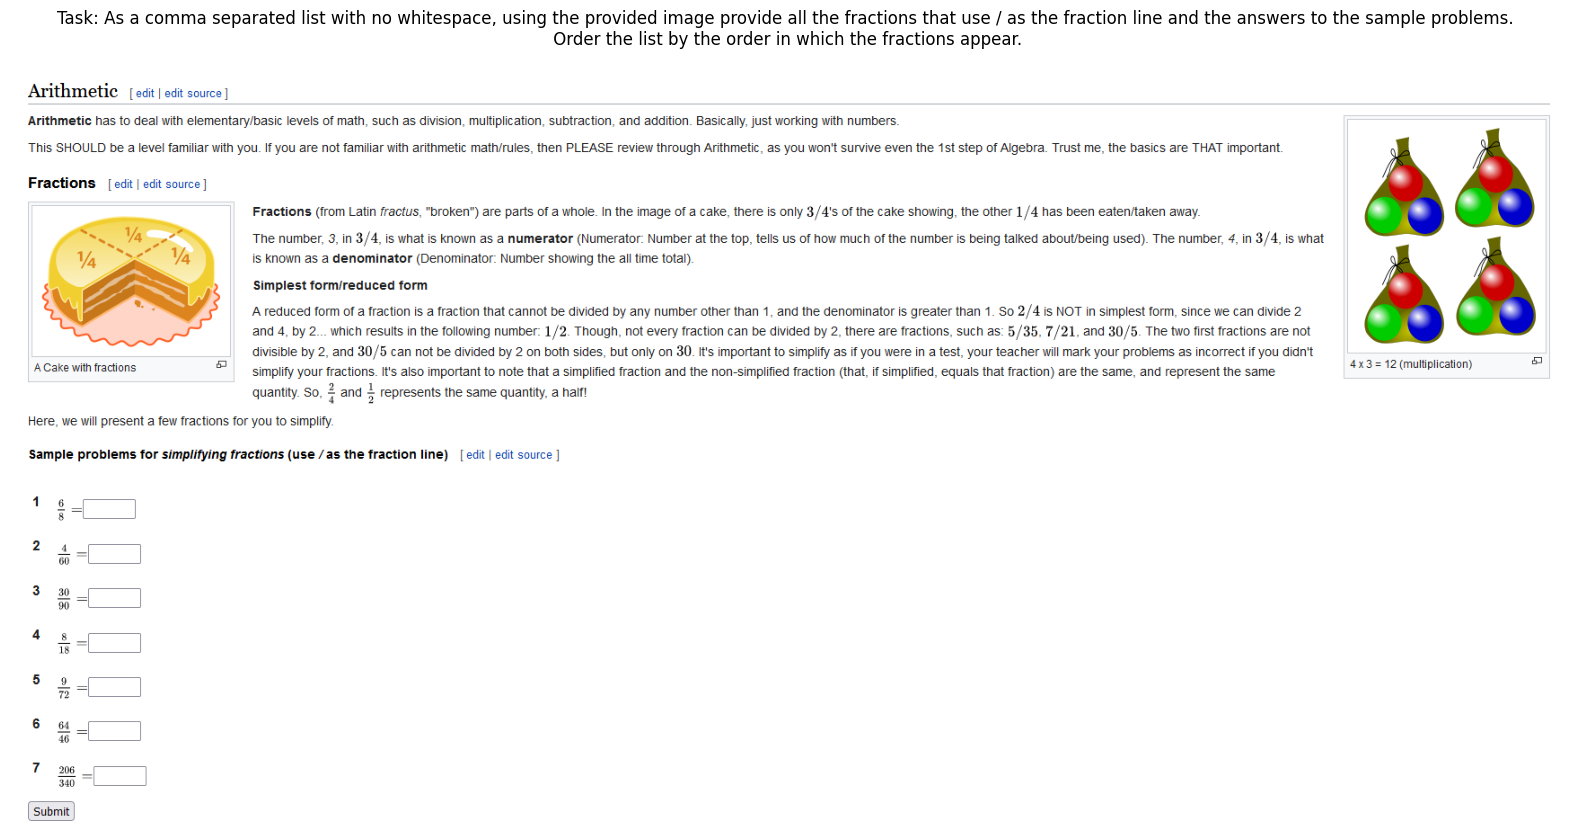

In [22]:
# Read Image
import matplotlib.pyplot as plt
from PIL import Image

img_path = sample_img_task.file_path
img = Image.open(img_path)
task_description = sample_img_task.Question

plt.figure(figsize=(20, 10))
plt.title("Task: " + task_description.replace(".", ".\n"))
plt.imshow(img)
plt.axis("off")
plt.show()

In [24]:
import easyocr

reader = easyocr.Reader(['en'])
results = reader.readtext(img_path)

for box, text, conf in results:
    print(f"Texto: {text} (Confianza: {conf:.2f})")


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Texto: Arithmetic (Confianza: 1.00)
Texto: edit (Confianza: 1.00)
Texto: edit source (Confianza: 1.00)
Texto: Arithmetic has to deal with elementarylbasic levels of math, such as division , multiplication , subtraction (Confianza: 0.51)
Texto: and addition_ Basically; just working with numbers (Confianza: 0.56)
Texto: This SHOULD be (Confianza: 0.98)
Texto: evel familiar with you_ If you are not familiar with arithmetic mathirules (Confianza: 0.60)
Texto: then PLEASE review through Arithmetic (Confianza: 0.94)
Texto: as you won't survive even the Ist step of Algebra (Confianza: 0.66)
Texto: Trust me (Confianza: 1.00)
Texto: the basics are THAT important (Confianza: 0.81)
Texto: Fractions (Confianza: 1.00)
Texto: edit (Confianza: 1.00)
Texto: edit source (Confianza: 1.00)
Texto: Fractions (from Latin fractus; "broken") are parts of a whole. In the image of a cake, there is only 3/4's of the cake showing (Confianza: 0.50)
Texto: the other 1/4 has been eatenitaken away: (Confianza: 0.84)


In [20]:
for r in results:
    print(r[1])

Arithmetic
edit
edit source
Arithmetic has to deal with elementarylbasic levels of math, such as division , multiplication , subtraction
and addition_ Basically; just working with numbers
This SHOULD be
evel familiar with you_ If you are not familiar with arithmetic mathirules
then PLEASE review through Arithmetic
as you won't survive even the Ist step of Algebra
Trust me
the basics are THAT important
Fractions
edit
edit source
Fractions (from Latin fractus; "broken") are parts of a whole. In the image of a cake, there is only 3/4's of the cake showing
the other 1/4 has been eatenitaken away:
The number; 3,in 3/4
is what is known as
numerator (Numerator: Number at the top, tells uS of how much of the number is being talked aboutbeing used) The number; 4, in 3/4
is what
1/4
Is known as
denominator (Denominator: Number showing the all time total)
Simplest formlreduced form
A reduced form of a fraction is
fraction that cannot be divided by
number other than
and the denominator is greater 

In [ ]:
result

In [ ]:
# Setup token processor and model

processor = DataProcessor
model = _(
    
)

In [ ]:
# Extract info from image

model.generate(
    query
    
    ids=processor.tokenizer
    tokens=512
)

In [ ]:
# Show both image and result

.batch

In [ ]:
donut.model()

In [ ]:
help(donut.model)

#### (2/2) YoLo for Object Detection 

### Integrate Tool and Experiment

---

## Audio Tool

Let's study where does our current Agent fail, especially on audio-like questions

In [ ]:
run = False

In [ ]:
gaia_df

### Identify Audio-like tasks

The first questions is to understand which questions need audio? 

* Hypothesis: Just look at such questions that have a .mp3 file attached


In [ ]:
# Gather a sample file from any task

audio_tasks = gaia_df[(gaia_df["file_path"].str.len()>0) & (gaia_df["file_path"].str.endswith(".mp3"))]
sample_task = audio_tasks.iloc[0]

In [ ]:
print(f"{(audio_tasks.shape[0] / gaia_df.shape[0]) * 100:.1f}% of tasks need audio processing")

In [ ]:
sample_task

In [ ]:
# Get the sample file

filepath = sample_task["file_path"]


Let's import the mp3 file with [ffmpeg](https://stackoverflow.com/questions/9458480/read-mp3-in-python-3#:~:text=%24%20ffmpeg%20%2Di%20foo.mp3%20%2Dvn%20%2Dacodec%20pcm_s16le%20%2Dac%201%20%2Dar%2044100%20%2Df%20wav%20foo.wav)

In [ ]:
temp_data_path = "/home/santiagoal/current-projects/chappie/data/temp-data/"

In [ ]:
if run:
    os.system(f"ffmpeg -i {filepath} -vn -acodec pcm_s16le -ac 1 -ar 44100 -f wav {temp_data_path}sample_audio.wav")

In [ ]:
if run:
    use_gpu = False
    model_size = "tiny"

    model = (
        whisper.load_model(model_size).cuda()
        if use_gpu
        else whisper.load_model(model_size)
    )

In [ ]:
print(filepath)

In [ ]:
if run: 
    raw_transcript = model.transcribe(
            filepath,
            word_timestamps=False,
            no_speech_threshold=0.5,
            condition_on_previous_text=True,
            compression_ratio_threshold=2.0,
        )

    transcript = raw_transcript["text"]
    print(transcript)

### Tool POC


In [ ]:

if run: 
    def transcriber(audio_path: str, ai_model = model) -> str:
        """
        Transcribes an audio file

        Parameters
        ----------
        audio_path : str
            Path to the audio file
        ai_model
            audio-to-text AI model 

        Returns:
            str: Text of the transcript 
        """
        raw_transcript = ai_model.transcribe(
            audio_path,
            word_timestamps=False,
            no_speech_threshold=0.5,
            condition_on_previous_text=True,
            compression_ratio_threshold=2.0,
        )

        transcript = raw_transcript["text"]

        return transcript

### Integrate Tool POC and experiment


The changes have been integrated, now we will experiment with the new version of the agent

In [ ]:
audio_tasks["Agent response"] = audio_tasks.apply(func=get_agent_response, axis=1)
audio_tasks["is_correct"] = audio_tasks.apply(func=eval_answer, axis=1)

In [ ]:
audio_tasks

In [ ]:
# Next steps: Update model... 